In [1]:
%matplotlib inline
import matplotlib.ticker as plticker
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sqlalchemy import create_engine, inspect, func


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
conn = engine.connect()
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

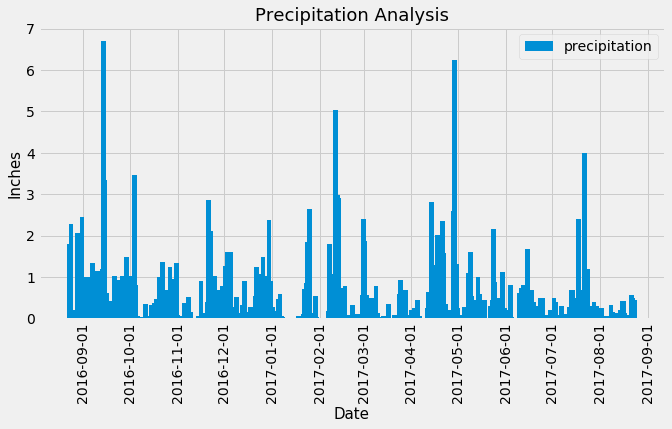

In [61]:
# Design a query to retrieve the last 12 months of precipitation data:
precip = session.query(Measurement.date, Measurement.prcp)\
        .filter((Measurement.date > '2016-08-22') & (Measurement.prcp != 'None')).all()
# save query to data frame:
precip_df = pd.DataFrame(np.array(precip), columns=['Date', 'Precipitation'])
# convert date format from string to date:
precip_df['Date'] = pd.to_datetime(precip_df.Date)
# sort values as required:
precip_df= precip_df.sort_values(by=['Date'], ascending=True)
# set column Date as index:
precip_df = precip_df.set_index("Date")
# convert Precipitation column values to float:
precip_df=pd.DataFrame(precip_df['Precipitation'].astype(float))


# plot the results:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(precip_df.index, precip_df['Precipitation'], label = "precipitation", width=3)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.set_xticks(precip_df.index)
ax.set_xticklabels(precip_df.index, rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.ylabel("Inches", fontsize = 15)
plt.xlabel("Date", fontsize = 15)
plt.title("Precipitation Analysis", fontsize=18)
plt.legend(loc='best')

# https://stackoverflow.com/ website learning materials used 
plt.savefig('output_images/precip_analysis.png', bbox_inches='tight')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data:
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
## inspect data and get columns:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

## count stations:
stations_count = session.query(Station.station).count()
print(f"There are {stations_count} stations in Hawaii")


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
There are 9 stations in Hawaii


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# join Measurement and Station tables and create a Data Frame:       
join_stations = session.query(Station.id, Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
join_stations_df = pd.DataFrame(np.array(join_stations), columns=['station_id', 'measurement_id', 'station', 'date', 'prcp', 'tobs'])
join_stations_df['date'] = pd.to_datetime(join_stations_df.date)

# define most active stations, convert to data frame and sort:
count_stations = join_stations_df.groupby('station')['tobs'].count()
count_stations=count_stations.to_frame().sort_values(by=['tobs'], ascending=False)
count_stations



,tobs
station,
USC00519281,24948
USC00519397,24516
USC00513117,24381
USC00519523,24021
USC00516128,23508
USC00514830,19818
USC00511918,17811
USC00517948,12348
USC00518838,4599


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# join_stations_df.loc['station' ==  'USC00519281']['tobs'].min()
act_station = join_stations_df.loc[join_stations_df.station == 'USC00519281',:]
low_temp = act_station.tobs.min()
print(f"The lowest temperature recorded by USC00519281 station was {low_temp} degree F,")        
high_temp = act_station.tobs.max()
print(f"the highest temperature recorded by the same station was {high_temp} degree F,")  
avg_temp = act_station.tobs.mean().round(1)
print(f"and the average temperature recorded by the most active station was {avg_temp} degree F.")  


The lowest temperature recorded by USC00519281 station was 54.0 degree F,
the highest temperature recorded by the same station was 85.0 degree F,
and the average temperature recorded by the most active station was 71.7 degree F.


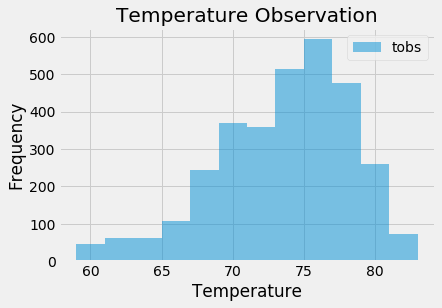

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp= act_station[['date', 'tobs']]
year_temp = year_temp.loc[year_temp.date > '2016-08-22']
year_temp = year_temp.set_index('date')
ax = year_temp.plot.hist(bins=12, alpha=0.5)
plt.xlabel('Temperature')
plt.title('Temperature Observation')

plt.savefig('output_images/temp_observ.png', bbox_inches='tight')

## Bonus Challenge Assignment


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.calc_temps('2016-08-14', '2016-08-31')
my_dates = calc_temps('2016-08-05', '2016-08-15')

trip_temp=[]
for list_value in my_dates:
    for tuple_value in list_value:
        trip_temp.append(tuple_value)

trip_temp

[71.0, 78.49295774647888, 83.0]

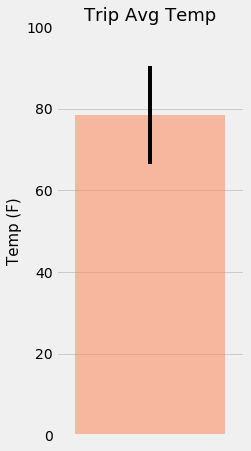

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_label=[4.5]

yer =[trip_temp[2] - trip_temp[0]] 
y_axis = trip_temp[1]

fig, ax = plt.subplots(figsize=(3,7))
ax.bar(x_label, y_axis, yerr=yer, color='coral', alpha = 0.5)

x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.xlim(4,5)
plt.ylim(0, 100)
plt.ylabel("Temp (F)", fontsize = 15)
plt.title("Trip Avg Temp", fontsize=18)
plt.savefig('output_images/trip_temp.png', bbox_inches='tight')

In [74]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#Query data for trip dates:
start_date = "2016-08-05"
end_date = "2016-08-15"
trip_rain = session.query(Measurement.station, Measurement.date,
                            Measurement.prcp, Station.name, Station.latitude,
                           Station.longitude, Station.elevation).filter(Station.station == Measurement.station).filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).filter(Measurement.prcp != 'None').all()

#Convert query result to Data Frame:
trip_rain_df = pd.DataFrame(np.array(trip_rain), columns=['Station', 'Date', 'Total Prcp', 
                                                          'Name', 'Lat', 'Lng', 'Elevation',])
#Convert precipitation values from string to float:
prcp=trip_rain_df['Total Prcp'].astype(float)
trip_rain_df['Total Prcp'] = prcp
#Calculate the total amount of rainfall per weather station, sort values in descending order:
trip_rain_df = trip_rain_df.groupby(['Station', 'Name', 'Lat', 'Lng', 'Elevation']).sum()
trip_rain_df = trip_rain_df.sort_values(by='Total Prcp', ascending = False)
trip_rain_df


,,,,,Total Prcp
Station,Name,Lat,Lng,Elevation,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,4.46
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,1.62
USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,1.16
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.61
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.46
USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.42
USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.03


In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [157]:
# Set the start and end date of the trip:
start_date = "2017-08-05"
end_date = "2017-08-15"

# Use the start and end date to create a range of dates:
trip_dates = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings:
date_range = trip_dates - pd.offsets.DateOffset(years=1)
date_range = pd.to_datetime(date_range)
date_range= (date_range.strftime('%m-%d')).to_list()

# calculate the daily normals for my trip, 
# and push each tuple of calculations into a list called `normals`:
normals=[]
# Loop through the list of %m-%d strings and calculate the normals for each date:
for date in date_range:
    normals.append(daily_normals(date))
normals

[[(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)]]

In [168]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.to_datetime(trip_dates)
trip_dates= (trip_dates.strftime('%Y-%m-%d')).to_list()


trip_normals=[]
for list_value in normals:
        for tuple_value in list_value:
            trip_normals.append(tuple_value)

trip = [] 
for min, avg, max in trip_normals:
    trip_dict ={}
    trip_dict['tmin'] = min
    trip_dict['tavg'] = avg
    trip_dict['tmax'] = max
    trip.append(trip_dict)
normals_df = pd.DataFrame(trip)
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')
    
normals_df



,tmin,tavg,tmax
Date,,,
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0
2017-08-10,65.0,76.420000,83.0
2017-08-11,67.0,75.981132,82.0
2017-08-12,67.0,76.527273,83.0
2017-08-13,71.0,76.982456,84.0


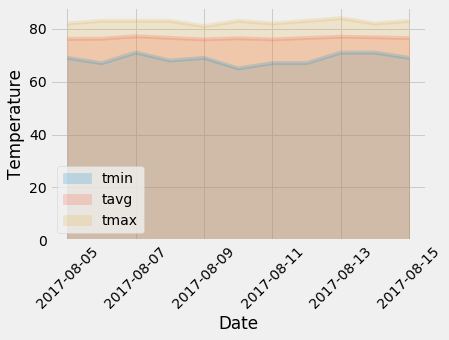

In [178]:
# Plot the daily normals as an area plot with `stacked=False`

ax = normals_df.plot.area(stacked=False, alpha=0.2)
ax.set_ylabel('Temperature')
plt.xticks(rotation=45)
plt.savefig('output_images/tnormals.png', bbox_inches='tight')

In [179]:
session.close()